In [1]:
#imports
import rasterio
import rioxarray
import glob
import datetime
import os
import xarray as xr
import netCDF4 as nc
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, poisson, gamma, gumbel_r
from collections import defaultdict
from scipy.stats import norm
from matplotlib import cm
import warnings
import fiona
import gc
import matplotlib as mpl

from myfunctions import clip_ds_monthly
from params import allnames, experiment_ids

xr.set_options(display_style='html')
plt.style.use('./science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False



/global/u1/c/cowherd/e3sm_eval/pipeline/myfunctions.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


/tmp/ipykernel_15395/622969783.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  ng.index = 0
TopologyException: Input geom 1 is invalid: Self-intersection at -73.151101703240116 -37.035200167727147


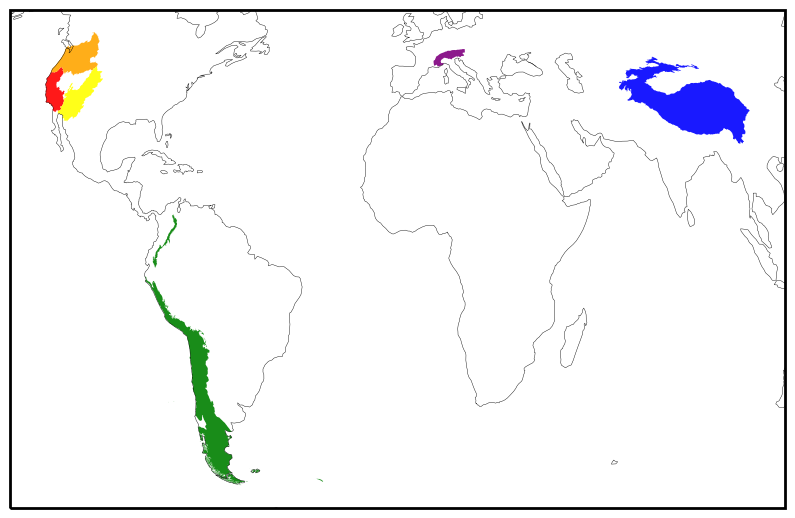

In [2]:
## LOAD SHAPEFILES FOR MAJOR WATER TOWER BASINS ##
huc2fn = '/global/cfs/cdirs/m4099/fate-of-snotel/huc2.shp'
basins = gpd.read_file(huc2fn) # ,layer = 'WBDHU2')
caregion = basins.loc[12]
# CO (upper and lower)
colorado1 = basins[(basins.index == 9)]
colorado1.index= [0]
colorado2 = basins[(basins.index == 13)]
colorado2.index= [0]
coloradogeom = colorado1.geometry.union(colorado2.geometry)
colorado = gpd.GeoDataFrame({'name':'Colorado'},index = [0], geometry = coloradogeom)
# PNW
pnw = basins[(basins.index == 15)]
pnw.index = [0]
# CA
california = basins[(basins.index == 12)]
california.index = [0]
#GMBA
GMBA = gpd.read_file('/global/cfs/cdirs/m4099/fate-of-snotel/GMBA_mountain_inventory.shp')
# Pan-Tibetan Highlands
pth_extents = gpd.read_file('https://github.com/xinluo2018/High-Moutain-Asia-GIS-Data/raw/e26c00bdd56f172773f8a85348f3e3c4047467a1/extents/HMA/hma(Pan_TPlateau)_liu2022_subregions.gpkg')
import shapely
gen = shapely.ops.polygonize(pth_extents.geometry[0])
pth = next(gen)
pth = gpd.GeoDataFrame({'name':'Pan-Tibetan Highlands'},index=[0], crs='epsg:4326', geometry=[pth])       
# Andes
andina = gpd.read_file('/global/cfs/cdirs/m4099/fate-of-snotel/RegionAndina.shp')
geom = andina.geometry[0]
for ng in andina.geometry:
    ng.index = 0
    try:
        geom = geom.union(ng)
    except:
        continue
        
andes = gpd.GeoDataFrame({'name':'Andes'}, index=[0], crs = 'epsg:4326', geometry = [geom])
# ALPS
# euro =gpd.read_file('/global/cscratch1/sd/cowherd/m_massifs_v1.shp')
# alps =euro[euro.index ==0].to_crs('epsg:4326')
alps = GMBA[GMBA.index == 583]
alps = gpd.GeoDataFrame({'name':alps.Name[583]},index = [0],  crs = 'epsg:4326', geometry = [alps.geometry[583]])

basins_to_plot = [colorado, california, pnw, pth, andes, alps]

import cartopy.crs as ccrs
fig = plt.figure(figsize=(10,10))
proj = ccrs.EqualEarth()
alpha =0.9
ax = fig.add_subplot(1,1,1,projection=proj)
california.to_crs(proj).plot(ax=ax, color = 'red', linewidth = 1, alpha = alpha)
pnw.to_crs(proj).plot(ax=ax, color = 'orange', linewidth = 1, alpha = alpha)
pth.to_crs(proj).plot(ax=ax, color = 'blue',linewidth = 1 ,alpha = alpha)
andes.to_crs(proj).plot(ax=ax, color = 'green',linewidth = 1, alpha = alpha)
alps.to_crs(proj).plot(ax=ax, color = 'purple', linewidth = 1, alpha =alpha)
colorado.to_crs(proj).plot(ax=ax, color = 'yellow', linewidth = 1, alpha =alpha)
ax.coastlines(lw=0.3)
ax.set_extent = ([-360, 0 , -90, -50], ccrs.PlateCarree())  
plt.show()

In [3]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                        andina: 499.8 KiB
                          GMBA: 154.2 KiB
                   pth_extents:  2.6 KiB
                            _i:  2.5 KiB
                           _i2:  2.5 KiB
                        basins:  1.9 KiB
                           _ii:  873.0 B
                           _i1:  873.0 B
                           _i3:  595.0 B
                   defaultdict:  408.0 B


In [4]:
files = glob.glob('/global/cfs/cdirs/e3sm/cowherd/swei_*')
s245data = []
s585data = []
coords = []

for fn in sorted(files):
    model = fn.split('_')[-1][0:-4]
    if model in allnames:
        try:
            era = fn.split('_')[1][-3:]
            sweidata = np.load(fn)
            clip = sweidata[:,:,:,:]
            if era == '585':
                s585data.append(clip)
            if era == '245':
                s245data.append(clip)
            tasdata = nc.Dataset(('/global/cfs/cdirs/e3sm/cowherd/tas_anom_%s_historical.nc')%(model))
            lat = tasdata['lat']
            lon = tasdata['lon']
            coords.append([lat,lon])
        except:
            print(model)

In [ ]:
## prep data for plotting ##
## this cell requires 7+ GB of available memory and takes a few minutes ##

## SSP 585 ##
nyr = 10
npd = int((2100-1850)/nyr)
nmod = len(s585data)
lines = {}
for basin in basins_to_plot:
    lines[basin.name[0]] = []
    for i in range(npd):
        lines[basin.name[0]].append([])
        
        ## 245 data ##
for i in range(nmod):
    categ = s245data[i]
    coord = coords[i]
    xdsvar = xr.Dataset(
        data_vars=dict(
            swei=(["ensyear","month","lat","lon"],categ),
        ),
        coords=dict(
            lon=(["lon"], np.array(coord[1])),
            lat=(["lat"], np.array(coord[0])),
            ensyear=range(categ.shape[0]),
            month = range(1,13)
        ),
    )
    for idx,basin in enumerate(basins_to_plot):
        clipped = clip_ds_monthly(xdsvar, basin = basin, lon_name = 'lon')
        data = clipped.swei.values.flatten()
        allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
        for i in range(npd):
            data2 = allmeans[i*6*nyr:((i*6*nyr)+nyr)]
            lines[basin.name[0]][i].append(data2)
            del data2
        gc.collect()
        del clipped, data
    gc.collect()
    del categ
    del coord
    del xdsvar
    
    
## SSP 585 ##
lines2 = {}
for basin in basins_to_plot:
    lines2[basin.name[0]] = []
    for i in range(npd):
        lines2[basin.name[0]].append([])
        
for i in range(nmod):
    categ = s585data[i]
    coord = coords[i]
    xdsvar = xr.Dataset(
        data_vars=dict(
            swei=(["ensyear","month","lat","lon"],categ),
        ),
        coords=dict(
            lon=(["lon"], np.array(coord[1])),
            lat=(["lat"], np.array(coord[0])),
            ensyear=range(categ.shape[0]),
            month = range(1,13)
        ),
    )
    for idx,basin in enumerate(basins_to_plot):
        clipped = clip_ds_monthly(xdsvar, basin = basin, lon_name = 'lon')
        data = clipped.swei.values.flatten()
        allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
        for i in range(npd):
            data2 = allmeans[i*6*nyr:((i*6*nyr)+nyr)]
            #pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
            #decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
            lines2[basin.name[0]][i].append(data2)
        gc.collect()
        del clipped, data
    gc.collect()
    del categ
    del coord
    del xdsvar


/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mean of empty slice
  allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mean of empty slice
  allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mean of empty slice
  allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mean of empty slice
  allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mean of empty slice
  allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mean of empty slice
  allmeans = np.nanmean(clipped.swei[:,[0,1,2,3,10,11],:,:],axis=(2,3)).flatten()
/tmp/ipykernel_15395/1105672528.py:32: RuntimeWarning: Mea

In [ ]:
cdicthist = {'red': [(0.0,  0.0, 0.0),
                     (1.0,  0.8, 0.8)],
             'blue': [(0.0,  0.0, 0.0),
                      (1.0,  0.8, 0.8)],
             'green': [(0.0,  0.0, 0.0),
                       (1.0,  0.8, 0.8)],} 

cdict585 = {'red': [(0.0, 1, 1),
                    (1.0,  0.545, 0.545)],
            'blue': [(0.0,  0.8, 0.8),
                     (1.0,  0.0, 0.0)],
            'green': [(0.0,  0.8, 0.8),
                      (1.0,  0.0, 0.0)],}

cdict245 = {'blue': [(0.0,  1.0, 1.0),
                     (1.0,  0.545, 0.545)],
            'red': [(0.0,  0.8, 0.8),
                    (1.0,  0.0, 0.0)],
            'green': [(0.0,  1.0, 1.0),
                      (1.0,  0.0, 0.0)],} 


cmap245 = mpl.colors.LinearSegmentedColormap('ssp245',cdict245,256)
cmap585 = mpl.colors.LinearSegmentedColormap('ssp585',cdict585,256)
cmaphist = mpl.colors.LinearSegmentedColormap('ssphist',cdicthist,256)


a=np.outer(np.arange(0,1,0.01),np.ones(100))

fig,axs = plt.subplots(1,3)
axs[0].imshow(a,aspect='auto', cmap =cmap245)                   
axs[1].imshow(a,aspect='auto', cmap =cmap585)                   
axs[2].imshow(a,aspect='auto', cmap =cmaphist)                   
plt.show()


subplot 0 line number  2 value  0.13883242851621103
subplot 0 line number  11 value  -0.04036240921743267
subplot 0 line number  24 value  -1.2330325841724283
subplot 0 line number  24 value  -1.4535541395467289
subplot 1 line number  2 value  0.09527033732063339
subplot 1 line number  11 value  0.2702898809621623
subplot 1 line number  24 value  -1.2078386035126596
subplot 1 line number  24 value  -1.396675775202603
subplot 2 line number  2 value  0.09125329025241574
subplot 2 line number  11 value  0.009119215725959057
subplot 2 line number  24 value  -0.8608781557387948
subplot 2 line number  24 value  -1.095893129720926
subplot 3 line number  2 value  0.10860458321384725
subplot 3 line number  11 value  -0.02417683064394588
subplot 3 line number  24 value  -1.2749699420170644
subplot 3 line number  24 value  -1.5164528760685227
subplot 4 line number  2 value  0.20320794768580414
subplot 4 line number  11 value  0.003049292596887465
subplot 4 line number  24 value  -1.05223342355306

/tmp/ipykernel_15395/3105703726.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


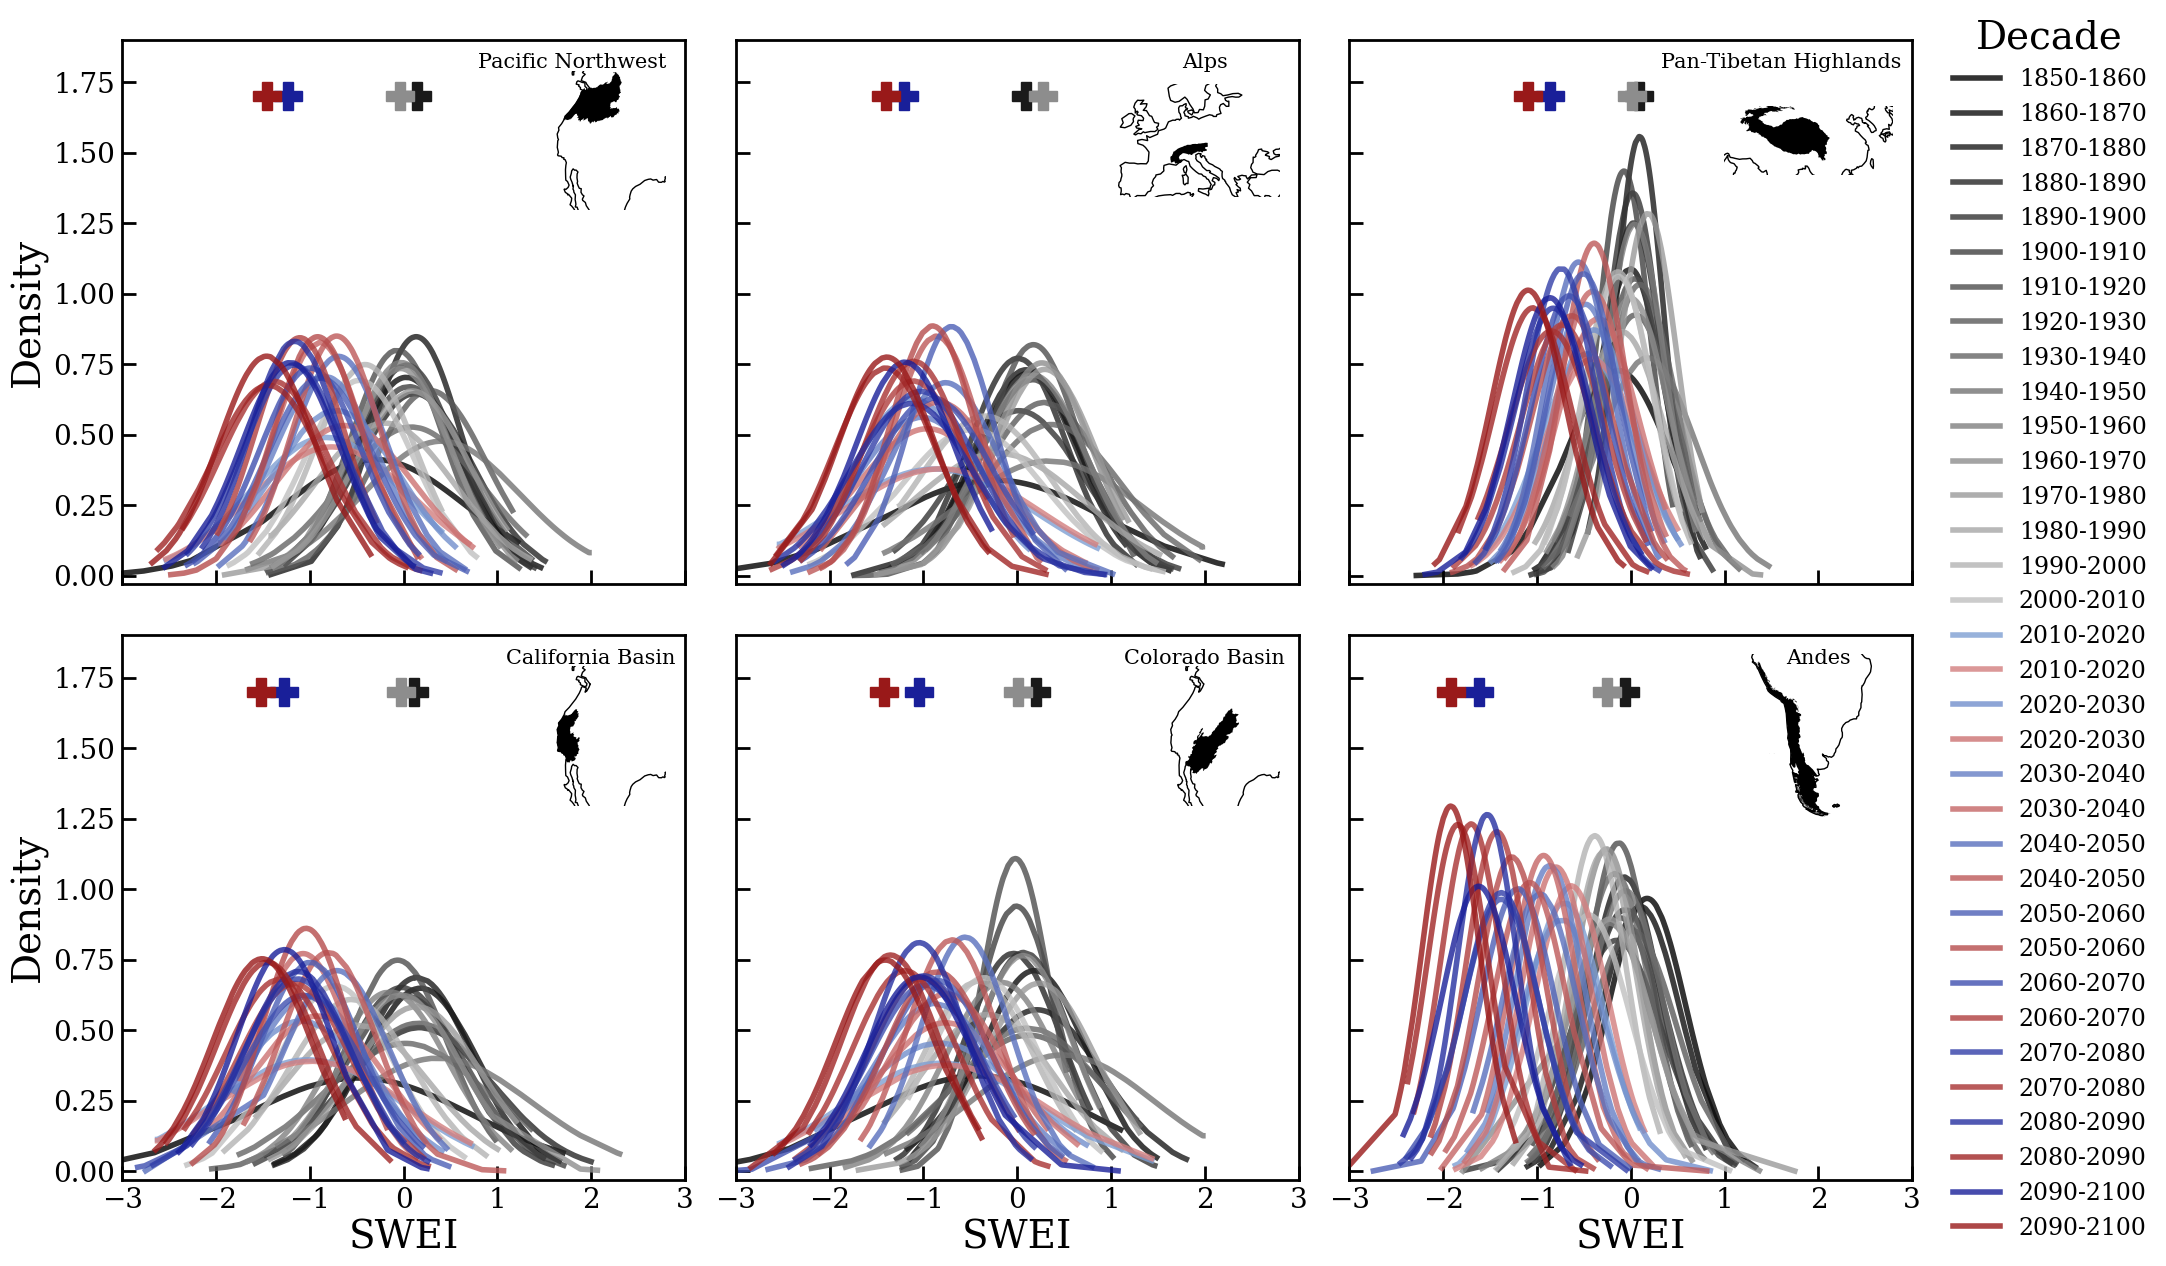

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
coast = gpd.read_file('ne_110m_coastline.shp')
from scipy.stats import norm

## aesthetics ##
nyr = 10
npd = int((2100-1850)/nyr)
colors_hist = cmaphist(np.linspace(0,1,int(npd/2)+5))
colors_245 = cmap245(np.linspace(0,1,int(npd/2)+5))
colors_585 = cmap585(np.linspace(0,1,int(npd/2)+5))
dotht = 1.7
alpha = 0.8
## 


## put them in approx geographical order
basins_to_plot = [pnw, alps, pth, california, colorado, andes]
## title and x location of title to plot in the subplot ## 
titles = [('Pacific Northwest',1.8), 
          ('Alps', 2),
          ('Pan-Tibetan Highlands',1.6),
          ('California Basin',2),
          ('Colorado Basin', 2),
          ('Andes',2)]

#baseline adjustments
baselines = []
for basin in basins_to_plot:
    name = basin.name[0]
    data = np.array(lines[name][0:5]).flatten()
    baselines.append(np.nanmean(data))
    
    
fig,ax=plt.subplots(2,3,figsize=(20,13))
axs = ax.flatten()
for idx,basin in enumerate(basins_to_plot):
    name = basin.name[0]
    baseline = baselines[idx]
    for i in range(0,int(npd/2)+4):
        data = lines[name][i]
        data2 = np.array(data).flatten() -baseline
        pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
        decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
        if idx == 5:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_hist[i],label = decade, alpha = alpha)
        else:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_hist[i], alpha = alpha)
        if i in [2,int(npd/2)-1, npd-1]:
            axs[idx].plot(pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())], dotht, color = colors_hist[i],marker = 'P', markersize = 20)
            print('subplot', idx, 'line number ', i, 'value ', pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())])

    for i in range(int(npd/2)+4, npd):
        starti = int(npd/2)-2
        ## ssp 245 #E
        data = lines[name][i]
        data2 = np.array(data).flatten() - baseline
        pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
        decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
        if idx == 5:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_245[i-starti],label = decade, alpha = alpha)
        else:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_245[i-starti], alpha = alpha)
        if i in [2,int(npd/2)-1, npd-1]:
            axs[idx].plot(pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())], dotht, color = colors_245[i-starti],marker = 'P', markersize = 20)
            print('subplot', idx, 'line number ', i, 'value ', pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())])

        ## ssp 585 ##
        data = lines2[name][i]
        data2 = np.array(data).flatten() - baseline
        pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
        decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
        if idx == 5:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_585[i-starti], alpha = alpha, label = decade)
        else:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_585[i-starti], alpha = alpha)
        if i == npd-1:
            axs[idx].plot(pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())], dotht, color = colors_585[i-starti],marker ='P', markersize = 20)
            print('subplot', idx, 'line number ', i, 'value ', pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())])
    
    #axs[idx].set_title(basin.name[0])
    axs[idx].text(titles[idx][1],dotht+0.1,titles[idx][0], fontsize = 15,  ha="center")
    axs[idx].set_xlim((-3,3))
    axs[idx].set_ylim((-0.03,1.9))
    axs[idx].tick_params(direction="in")
    gc.collect()
    
[axs[i].set_xlabel('SWEI') for i in [3,4,5]]
[axs[i].set_ylabel('Density') for i in [0,3]]
[axs[i].tick_params(labelbottom = False) for i in [0,1,2]]
[axs[i].tick_params(labelleft = False) for i in [1,2,4,5]]

## add geometries ##
kwargs = {'frameon':False,
         'xticklabels': [],
         'yticklabels': []}

## basin object with shape included, xlims, ylims  ##
geom_args = [(pnw, [-1.2e7,-0.8e7], [3.0e6,6.3e6]),
             (alps, [-0.1e7,0.3e7], [4.5e6,7.2e6]),
             (pth, [0.5e7,1.2e7], [2.5e6,5.4e6]),
             (california, [-1.2e7,-0.8e7], [3.0e6,6.3e6]),
             (colorado, [-1.2e7,-0.8e7], [3.0e6,6.3e6]),
             (andes, [-0.8e7,-.33e7], [-6.6e6,-0.5e6])]

for i, geom_arg in enumerate(geom_args):
    inset_ax = inset_axes(axs[i], width="30%",  height="30%", loc=1, borderpad = 0.8, axes_kwargs=kwargs)
    inset_ax.tick_params(bottom=False)
    inset_ax.tick_params(left=False)
    # inset_ax.text(0,0,basins_to_plot[i].name[0])
    geom_arg[0].to_crs(proj).plot(ax=inset_ax, color = 'k', linewidth = 1, alpha = 1)
    coast.to_crs(proj).plot(ax=inset_ax, linewidth = 1)
    inset_ax.set_xlim(geom_arg[1])
    inset_ax.set_ylim(geom_arg[2]) 

fig.legend(title = 'Decade', bbox_to_anchor=(1.1, 1.),ncol=1)
fig.tight_layout()
plt.show()


In [ ]:
## calculate statistics




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


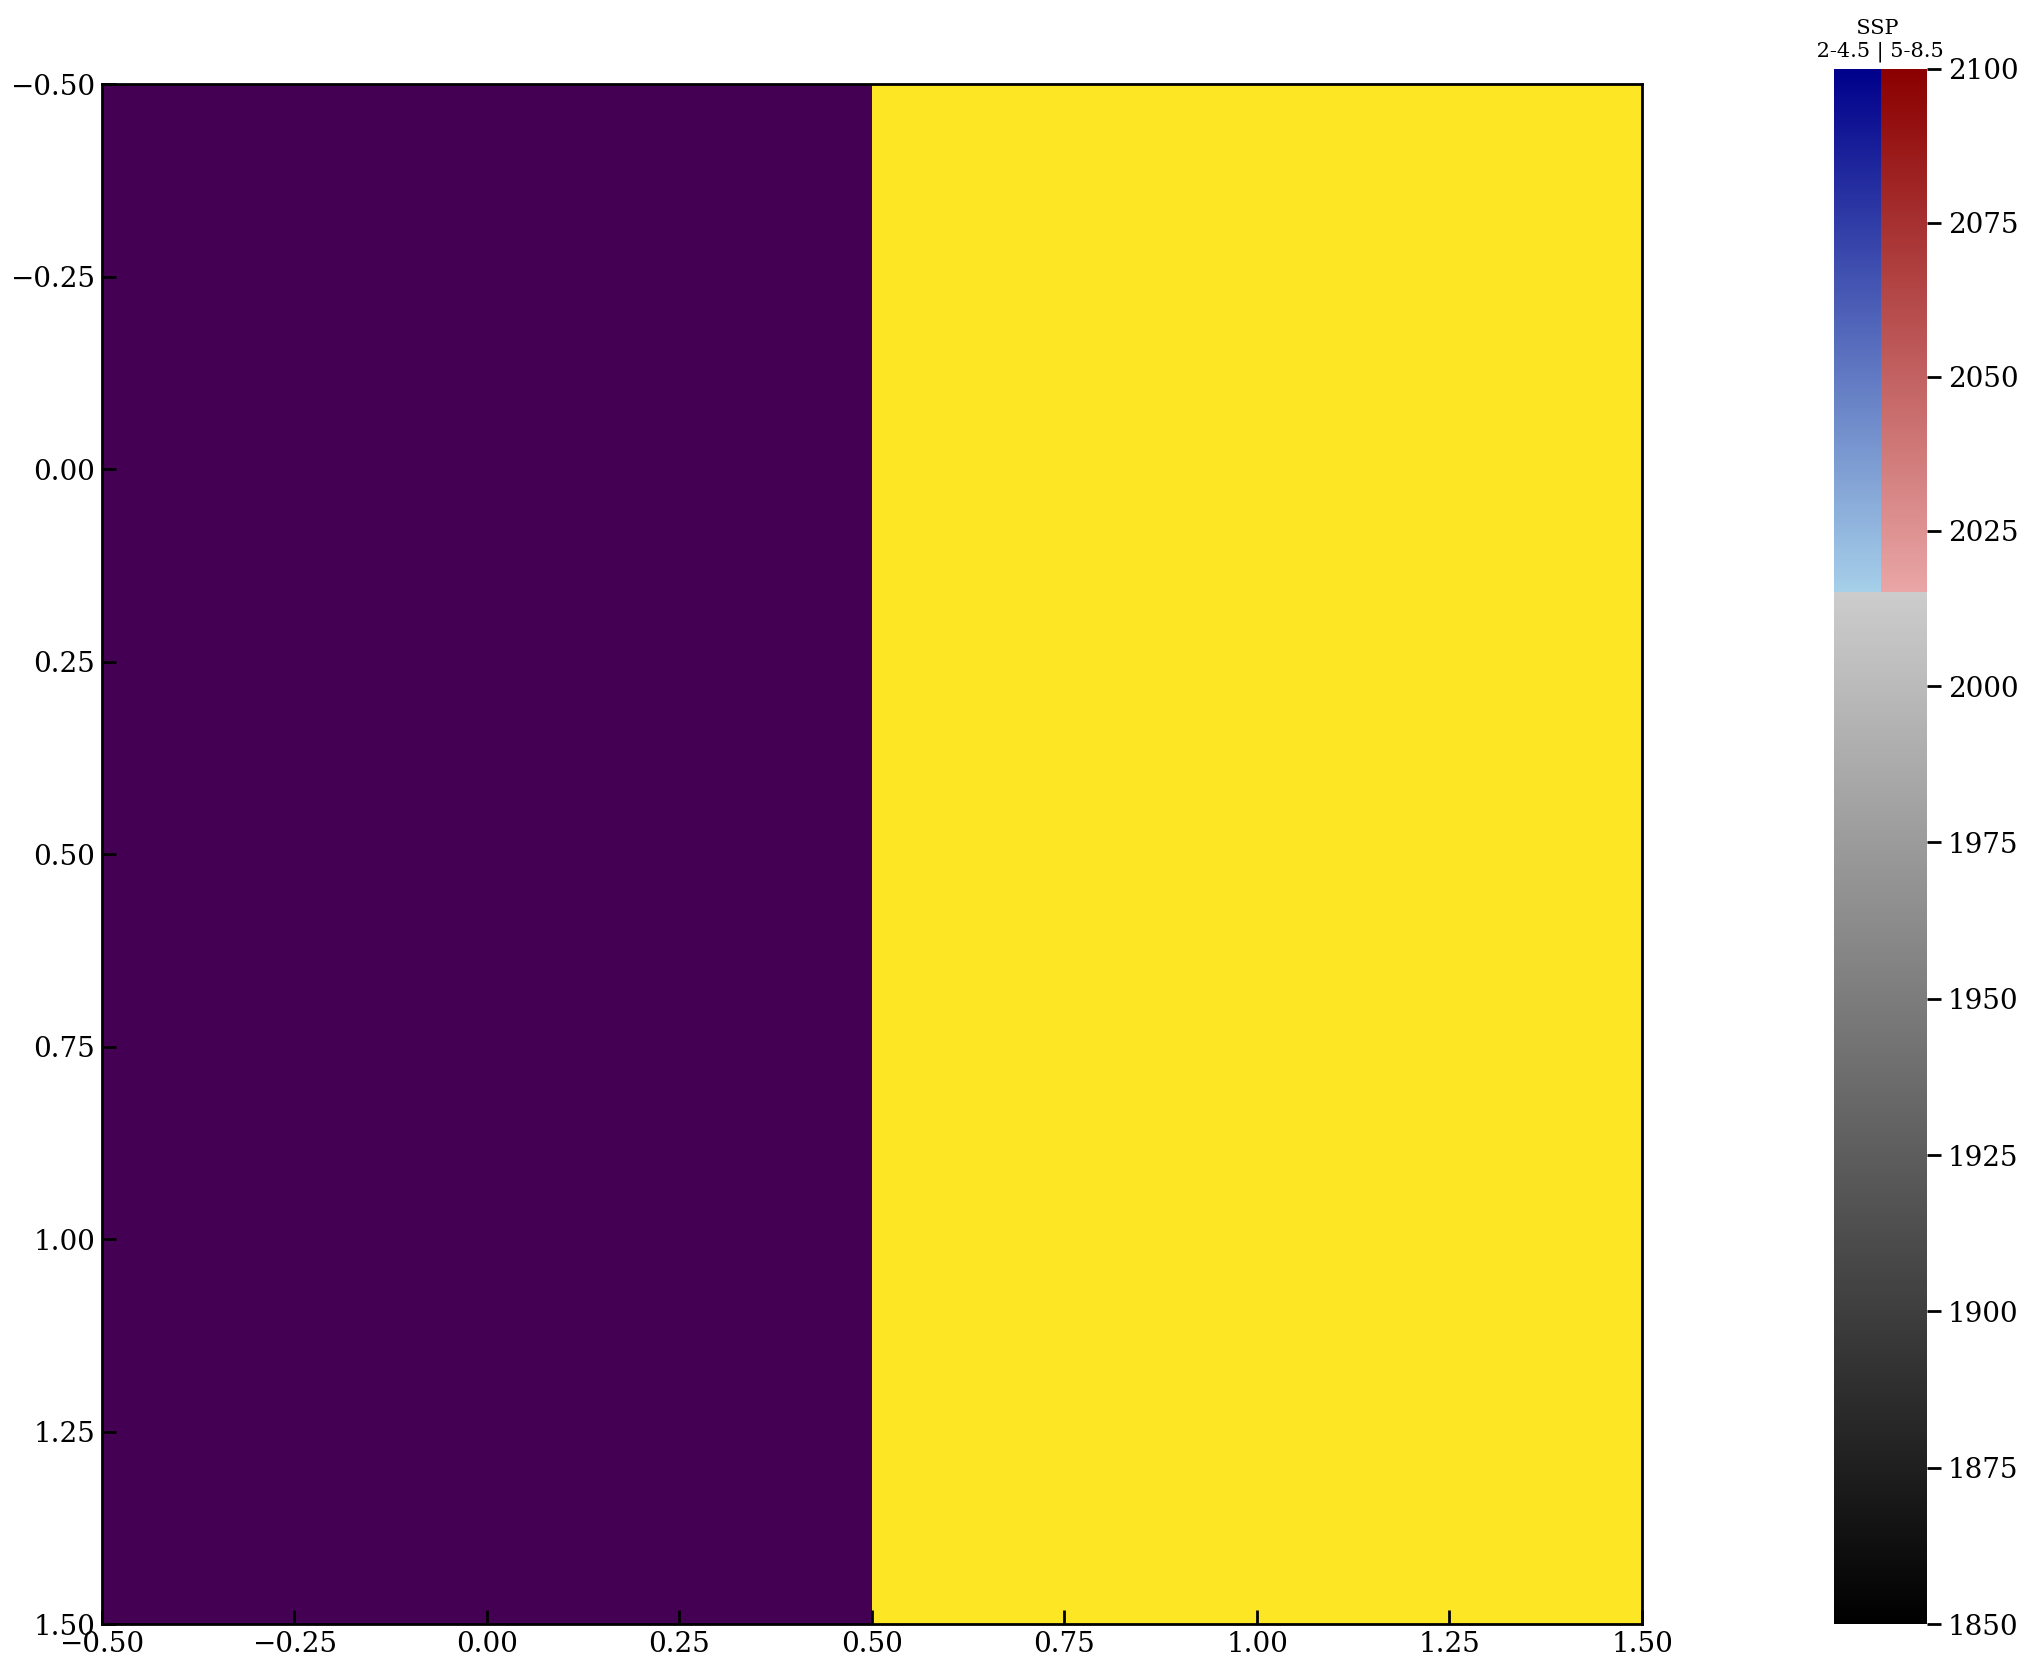

In [8]:
## generate replacement colormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
colors1 = cm.coolwarm(np.linspace(0,1,npd))[0:int(npd/2)] ##1 = Red
colors2 = cm.coolwarm(np.linspace(0,1,npd))[int(npd/2):-1] ## 2 = Blue
colors3 = cm.Greys(np.linspace(0,1,npd))[int(npd/2):-1] ## 3 = Gray
mymap1 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_hist)
mymap2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_245[3:])
mymap3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_585[3:])

fig, ax = plt.subplots(figsize=(20,20))
im1 = ax.imshow(np.meshgrid([[1850,2015],[1850,2015]]), cmap = mymap1)
im2 = ax.imshow(np.meshgrid([[2015,2100],[2015,2100]]), cmap = mymap2)
im3 = ax.imshow(np.meshgrid([[2015,2100],[2015,2100]]), cmap = mymap3)
im4 = ax.imshow([[0,1],[0,1]])

axins1 = inset_axes(ax,
    width="6%",  # width: 5% of parent_bbox width
    height="67%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.125, 0.0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins2 = inset_axes(
    ax,
    width="3%",  # width: 5% of parent_bbox width
    height="34%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.125, 0.67, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins3 = inset_axes(
    ax,
    width="3%",  # width: 5% of parent_bbox width
    height="34%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.155, 0.67, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cb = plt.colorbar(im1, cax=axins1, ticks=np.linspace(1850,2100,int(npd/2)-1), drawedges=False)
cb.ax.tick_params(axis='y', direction='out')
cb.outline.set_visible(False)
cb = plt.colorbar(im2, cax=axins2, ticks=[])
cb.outline.set_visible(False)
cb=plt.colorbar(im3, cax=axins3, ticks=np.linspace(1850,2100,int(npd/2)-1))
cb.ax.tick_params(axis='y', direction='out')
cb.outline.set_visible(False)
fig.legend(title = '       SSP\n 2-4.5 | 5-8.5', bbox_to_anchor=(1.059, 0.923),ncol=1,title_fontsize=15,alignment = 'center')
plt.show()